In [118]:
import cirq
import numpy as np
import matplotlib.pyplot as plt 

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

In [119]:
# Goal: Simulate an Ising chain of n-qubits, using only log(n) qubits
# Specifically, the paper does a four qubit Ising chain using two qubits
# We must decompose the circuits for compressed simulation into the available gate set.
# We must also run the experiment often enough so that statistical errors are reduced
# Systematic errors must be estimated using independent controlled circuits of 
# similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

# Introduction
Akash or whoever
Goal: Simulate an Ising chain of n-qubits, using only log(n) qubits
Specifically, the paper does a four qubit Ising chain using two qubits
We must decompose the circuits for compressed simulation into the available gate set.
We must also run the experiment often enough so that statistical errors are reduced
Systematic errors must be estimated using independent controlled circuits of 
similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

# Step 1
Prepare the input state $\rho_{i n} = \frac{1}{2^{m-1}} I^{\otimes m-1} \otimes |+_{y} \rangle \langle+_{y} |$ where $Y |+_{y} \rangle=|+_{y} \rangle$ by applying $S^{\dagger}H$ on qubit $0$, $H$ on an auxilirary qubit $2$, and $CNOT$ on qubits $1$ and $2$ with qubit $1$ being the target and qubit $2$ the control.

In [120]:
qubits = cirq.LineQubit.range(3)
qubit0, qubit1, qubit2 = qubits

circuit = cirq.Circuit()

circuit.append([cirq.H(qubit0)])
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit2)])
circuit.append([cirq.CNOT(control=qubit2, target=qubit1)])

circuit

0: ───H───S^-1───

1: ───────X──────
          │
2: ───H───@──────

# Step 2
Evolve the system up to the desired value of $J$, which in this particular case is $J = 1$, by decomposing the evolutionary operator $W(J)=\prod_{l=1}^{L(J)} U_{d} R_{l}^{T} R_{0}^{T}$ into the Clifford+T gate set. This is done, rather than decomposing each step in the adiabatic evolution $U_{d} R_{l}^{T} R_{0}^{T}$, in order to keep the total circuit depth practically feasible.

In [121]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.S(qubit0)])
circuit.append([cirq.T(qubit1)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.Z(qubit1)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])

Apply $(THS)^4$ on qubit $0$:

In [122]:
for _ in range(4):
    circuit.append([cirq.S(qubit0)])
    circuit.append([cirq.H(qubit0)])
    circuit.append([cirq.T(qubit0)])

In [123]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

# Step 3
Measure $Y$ on qubit $0$ to obtain the magnetization. In particular, ... [Henry eigenspaces, expected value, etc https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements?view=qsharp-preview]

In [124]:
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit0)])

Preserve the wave function of the system prior to measurement:

In [125]:
simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)

In [126]:
circuit.append([cirq.measure(first, key='x')])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───S^-1───H───M('x')───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

# Wave Function
Victor / whoever else 

In [127]:
wave_function

measurements: (no measurements)
output vector: (-0.107-0.184j)|000⟩ + (0.184-0.107j)|001⟩ + (-0.055+0.206j)|010⟩ + (0.206+0.055j)|011⟩ + (-0.258-0.372j)|100⟩ + (0.372-0.258j)|101⟩ + (-0.081+0.445j)|110⟩ + (0.445+0.081j)|111⟩

calculate expected value

In [128]:
final_state = wave_function.final_state

p_qubit0_0 = (sum([np.absolute(i)**2 for i in final_state[0:4]]))
p_qubit0_1 = (sum([np.absolute(i)**2 for i in final_state[4:8]]))

exp_val_wfn = 1 * p_qubit0_0 + -1 * p_qubit0_1

exp_val_wfn

-0.6370238384257774

# Measured Outcome
Akash / whoever else

In [129]:
n = 1000000
results = simulator.run(circuit, repetitions=n)

Create normalized histogram of results

Counter({1: 0.818458, 0: 0.181542})


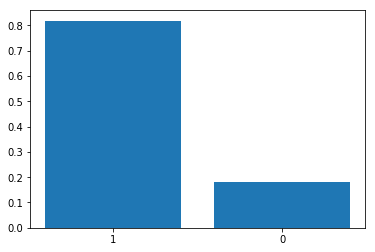

In [130]:
hist = results.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v / n
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

calculate expected value

In [131]:
p0 = hist[0]
p1 = hist[1]

exp_val_meas = 1 * p0 - 1 * p1

exp_val_meas

-0.636916

# Theoretical Prediction
Allen and Henry

# Final Results
Allan

In [132]:
# J = 1
# https://github.com/quantumlib/Cirq/blob/master/examples/quantum_teleportation.py
    # Creates Bell state to be shared between Alice and Bob
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])
    # Creates a random state for the Message
    circuit.append([cirq.X(msg)**ranX, cirq.Y(msg)**ranY])
    # Bell measurement of the Message and Alice's entangled qubit
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg)])
    circuit.append(cirq.measure(msg, alice))
    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum Message on Bob's entangled qubit
    circuit.append([cirq.CNOT(alice, bob), cirq.CZ(msg, bob)])

IndentationError: unexpected indent (<ipython-input-132-741bcf1e5b15>, line 4)